In [68]:
from atproto import Client
import spacy
from urlextract import URLExtract
import pandas as pd
import demoji
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import contractions
import re
from spacy.lang.en.stop_words import STOP_WORDS



url_extractor = URLExtract()
nlp = spacy.load("en_core_web_sm")

plt.style.use('ggplot')

In [9]:
HANDLE = 'asinvader.bsky.social'
KEY = os.getenv('BSKEY')

In [10]:
os.getenv('KSKEY')

In [11]:
from atproto import Client

# Initialize the client
client = Client()

# Log in with your handle and password
client.login(HANDLE, KEY)



ProfileViewDetailed(did='did:plc:4i6qiursww27bmbp57dcxejx', handle='asinvader.bsky.social', associated=ProfileAssociated(chat=ProfileAssociatedChat(allow_incoming='following', py_type='app.bsky.actor.defs#profileAssociatedChat'), feedgens=0, labeler=False, lists=0, starter_packs=0, py_type='app.bsky.actor.defs#profileAssociated'), avatar='https://cdn.bsky.app/img/avatar/plain/did:plc:4i6qiursww27bmbp57dcxejx/bafkreifgbp5xzfhfuzapnjaq2n2uki5bs22xexbh4kluzcwhojxp3hxu5m@jpeg', banner=None, created_at='2024-09-17T18:47:31.042Z', description='MARX | MYTH | MACHINE LEARNING', display_name='asinvader', followers_count=20, follows_count=560, indexed_at='2024-11-21T01:33:43.935Z', joined_via_starter_pack=None, labels=[], pinned_post=None, posts_count=5, viewer=ViewerState(blocked_by=False, blocking=None, blocking_by_list=None, followed_by=None, following=None, known_followers=KnownFollowers(count=6, followers=[ProfileViewBasic(did='did:plc:zms5ores7wvtkawzxr6no5gw', handle='paullangley.bsky.soc

In [12]:
# Retrieve your profile information
profile = client.get_profile(client.me.did)

# Access and print the number of followers
follower_count = profile.followers_count
print(f'You have {follower_count} followers.')

You have 20 followers.


In [5]:
my_did = client.me.did

# Fetch the list of followers
#response = client.app.bsky.graph.get_followers({'actor': my_did})
response = client.get_follows(actor = HANDLE)
followers = response['follows']

In [85]:
BASE_CLEAN_TEXT_RESPONSE = {'text':None,'clean_text':None,'url':None}
URL_PLACEHOLDER = '[URL]'
EMOJI_PLACEHOLDER = '[E]'


def clean_text(text, spacy_nlp, url_extractor):

    if not text:
        return BASE_CLEAN_TEXT_RESPONSE
    
    text = text.replace('\n',' ')
    text = contractions.fix(text)
    urls = url_extractor.find_urls(text)
    emojis = demoji.findall(text)

    doc = None
    
    if len(urls):
        for url in urls:
            #doc = text.replace(url, ' ')
            text = text.replace(url, URL_PLACEHOLDER)
            
    if len(emojis):
        for emoji in emojis:
            #doc = text.replace(emoji, ' ')
            text = text.replace(emoji, EMOJI_PLACEHOLDER)
            

    doc = text.replace(URL_PLACEHOLDER, ' ')
    doc = doc.replace(EMOJI_PLACEHOLDER, ' ')
    doc = spacy_nlp(doc)
    
    filtered_tokens = [token.text for token in doc if (token.is_alpha or token.is_digit) and not token.is_stop and not token.is_punct]

    reconstructed_string = ' '.join(filtered_tokens)
    

    return {
        'text':text,
        'clean_text':reconstructed_string,
        'url':urls,
        'emojis':emojis
    }

In [60]:

STOP_WORDS

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [86]:
def compile_descriptions(raw_data, nlp, url_extractor):
    descriptions = []
    for datum in raw_data:
        descriptions.append(clean_text(datum.description, nlp, url_extractor))

    return pd.DataFrame(descriptions)


def get_all_follows(client, user_id):

    raw_data = client.get_follows(actor = user_id)
    cursor = raw_data['cursor']
    follows = raw_data['follows']

    while cursor:
        raw_data = client.get_follows(actor = user_id, cursor = cursor)
        follows += raw_data['follows']
        cursor = raw_data['cursor']
        

    return follows

In [31]:
tmp = get_all_follows(client, HANDLE)

In [87]:
follows = compile_descriptions(tmp, nlp, url_extractor)

political     140
professor     103
university    101
climate        85
history        69
economy        67
author         60
politics       59
games          54
research       53
social         48
science        45
prof           43
director       40
editor         39
economic       38
associate      37
co             37
book           37
historian      36
Name: count, dtype: int64

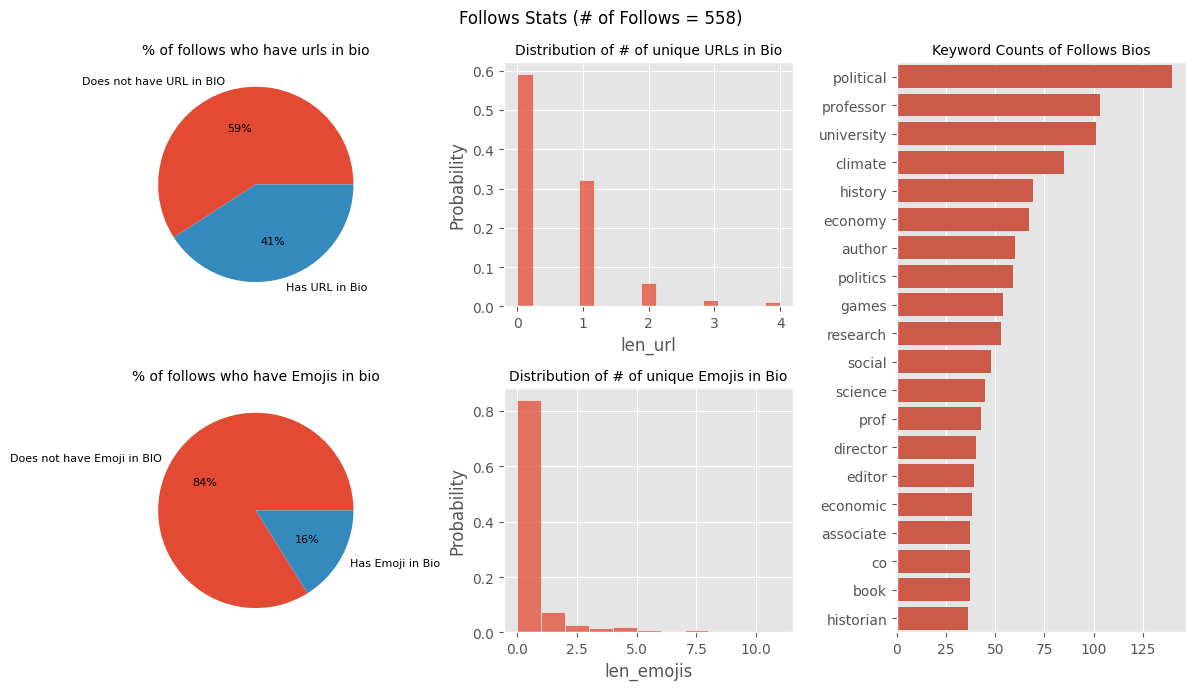

In [97]:
follows['len_url'] = follows['url'].apply(lambda x: len(set(x)) if type(x) == list else 0)
follows['len_emojis'] = follows['emojis'].apply(lambda x: len(set(x)) if type(x) == dict else 0)
kw_count = pd.Series([ i for j in follows['clean_text'].str.lower().str.split().tolist() if j is not None for i in j ]).value_counts()


fig = plt.figure(figsize  = (12,7))

ax1 = fig.add_subplot(2,3,1)
tmp = follows['len_url'].apply(lambda x: 'Has URL in Bio' if bool(x) else 'Does not have URL in BIO').value_counts() * 100 / follows.shape[0]
ax1.pie(tmp, labels = tmp.index.tolist(), autopct='%.0f%%', textprops={'fontsize': 8})
ax1.set_title("% of follows who have urls in bio", fontsize = 10)

ax2 = fig.add_subplot(2,3,2)
sns.histplot(data = follows, x = 'len_url', stat = 'probability', ax = ax2)
ax2.set_title('Distribution of # of unique URLs in Bio', fontsize = 10)
plt.tight_layout()

ax3 = fig.add_subplot(2,3,4)
tmp = follows['len_emojis'].apply(lambda x: 'Has Emoji in Bio' if bool(x) else 'Does not have Emoji in BIO').value_counts() * 100 / follows.shape[0]
ax3.pie(tmp, labels = tmp.index.tolist(), autopct='%.0f%%', textprops={'fontsize': 8})
ax3.set_title("% of follows who have Emojis in bio", fontsize = 10)

ax4 = fig.add_subplot(2,3,5)
sns.histplot(data = follows, x = 'len_emojis', stat = 'probability', ax = ax4)
ax4.set_title('Distribution of # of unique Emojis in Bio', fontsize = 10)

ax5 = fig.add_subplot(1,3,3)
sns.barplot(x = kw_count.head(20).tolist(), y = kw_count.head(20).index.tolist(), ax = ax5)
ax5.set_title('Keyword Counts of Follows Bios', fontsize = 10)

fig.suptitle(f'Follows Stats (# of Follows = {follows.shape[0]:.0f})')
plt.tight_layout()
plt.show()


Up next:

- Create basic streamlit app that takes in bluesky handle and emits some aggregate stats

----------------

In [42]:
209000.00 + 204500.00 + 418000.00 + 409000.00 + 313500.00 + 306750.00 + 1000000.00 + 250000.00 + 250000.00 + 250000.00 + 250000.00 + 418000.00 + 106340.00 + 106340.00 + 106340.00 + 106340.00 + 1045000.00 + 265850.00 + 265850.00 + 270213.00 + 104500.00 + 418000.00 + 209410.00 + 418000.00 + 208590.00 + 627000.00 + 613500.00 + 444125.00 + 418000.00 + 1045000.00 + 156750.00

11213898.0

In [46]:
11213898.0 + 209001 + 104501 + 418000 + 209001 + 408999 + 204499

12767899.0

In [47]:
12767899.0 + 418000

13185899.0

In [ ]:
13185899.0